In [1]:
from math import pi, sin, cos
from collections import Sequence
from pprint import pprint

class Lsystem(Sequence):
    """A class representing an abstract sequence of lsystem iterations."""
    def __init__(self, start, rules, max_iters=5, angle=90, bindings={}):
        self.start = start
        self.rules = rules
        self.max_iters = max_iters
        self._cache = []
        self._bindings = {}
        self.set_default_bindings(angle)
        if bindings:
            self.set_bindings(bindings)

    @classmethod
    def from_lsbot(cls, start, rules, a=90, iter=5, wiggly=None, bindings={}):
        """Designed to accept the lsystem representation used by the LSystem Bot,
           which is why it masks the `iter` built-in."""
        return cls(start, rules, iter, a, bindings=bindings)
        
    def set_default_bindings(self, angle=90):
        self.bind_push('[')
        self.bind_pop(']')
        self.bind_turn('+', angle)
        self.bind_turn('-', -angle)
        self.bind_step('F', 1)
        
    def set_bindings(self, bindings):
        self._bindings.update(bindings)
    
    def get_bindings(self):
        return self._bindings
    
    def bind_push(self, char):
        self._bind('push', char)

    def bind_pop(self, char):
        self._bind('pop', char) 
        
    def bind_turn(self, char, arg):
        self._bind('turn', char, arg)
    
    def bind_step(self, char, arg):
        self._bind('step', char, arg)
    
    def _bind(self, action, char, arg=None):
        self._bindings[char] = (action, arg)
        
    def interpret(self, ix):
        state = self[ix]
        position = (0, 0)
        heading = 0
        stack = []
        points = [[position]]
        for c in state:
            if c not in self._bindings:
                continue
            method, arg = self._bindings[c]
            if method == 'push':
                stack.append((position, heading))
            elif method == 'pop':
                position, heading = stack.pop()
                points.append([position])
            elif method == 'turn':
                heading += arg
            elif method == 'step':
                x, y = position
                x += arg * cos(pi * heading / 180)
                y += arg * sin(pi * heading / 180)
                position = x, y
                points[-1].append(position)

        return points

    @staticmethod
    def lsystem_step(state, rules):
        lstring_subs = [rules[c] if c in rules else c
                        for c in state]
        return ''.join(lstring_subs)

    def __len__(self):
        return self.max_iters

    def __getitem__(self, ix):
        if -self.max_iters <= ix < 0:
            ix = self.max_iters - ix

        last = len(self._cache)
        if last <= ix < self.max_iters:
            state = self._cache[-1] if self._cache else self.start
            for n in range(last, ix + 1):
                state = self.lsystem_step(state, self.rules)
                self._cache.append(state)

        return self._cache[ix]



In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from matplotlib import pyplot as plt

def plot_series(series, 
                colormap='viridis',  # 'plasma' also good
                linewidth=0.25,
                clearfig=True,
                savefig=False):
    if clearfig:
        plt.clf()
    minx = min(x for X, Y in series for x in X)
    miny = min(y for X, Y in series for y in Y)
    maxx = max(x for X, Y in series for x in X)
    maxy = max(y for X, Y in series for y in Y)
    padding = (maxx - minx) * 1.0 / 10
    minx -= padding
    miny -= padding
    maxx += padding
    maxy += padding
    
    cmap = plt.get_cmap(colormap)
    colors = [cmap(i * 1.0 / len(series)) for i in range(len(series))]
    for i, (x, y) in enumerate(series):
        plt.plot(x, y, linewidth=linewidth, color=colors[i])

    plt.xlim((minx, maxx))
    plt.ylim((miny, maxy))
    plt.axes().set_aspect('equal')
    if savefig:
        if isinstance(savefig, basestring):
            plt.savefig('{}.pdf'.format(savefig))
        else:
            plt.savefig('untitled.pdf')

In [3]:
# Straight from LsystemBot 2.0:
star = {"start":"M",
        "rules":{"F":"[[FF]M]","M":"MFMF+"},"a":60,"iter":10}
kite_thing = {"start":"GFGF",
              "rules":{"F":"+[-]","G":"GFFGFF"},"a":36,"iter":10}
triangle_plant = {"start":"GEE",
                  "rules":{"F":"[]+D+","D":"-D-GG-EFF","G":"E","E":"F[GFE++]DF"},"a":60,"iter":10}
plant = {'start': 'X', 
         'rules': {'X': 'F−[[X]+X]+F[+FX]−X', 'F': 'FF'}, 'a': 25, 'iter': 10}
wright = {"start":"LLLF",
          "rules":{"F":"FF","L":"-FFXF-XL","X":"F[F-]FXL"},"a":90,"iter":10}
swirl = {"start":"FFFF",
         "rules":{"F":"[FS----E]-","E":"[]F-F+-[+]","S":"[[+]F]F"},"a":36,"iter":10}
rand_koch = {"start":"FFU",
             "rules":{"F":"J+J--FF","U":"-F","J":"-"},"a":60,"iter":10}
squiggle = {"start":"PA",
            "rules":{"F":"+F","P":"-F[+P]","A":"AAF++--F","W":"[F]FF+"},"a":36,"iter":10}
lattice = {"start":"NFF",
           "rules":{"F":"F+F++","N":"-+NFF","L":"[[]]FLL-FFF"},"a":60,"iter":10}
curl = {u'a': 45, u'iter': 12, 
        u'rules': {u'F': u'TFFT', u'G': u'[-F]-', u'T': u'[---]-'}, u'start': u'FTT', u'wiggly': True}
parquetblob = {
    u'a': 90,
    u'iter': 7,
    u'rules': {u'E': u'+[E]',
               u'F': u'EF[E]FWE+F',
               u'Q': u'[[+][]]',
               u'W': u'[[WF]]Q'
              },
    u'start': u'QFEQ'
}
hexcomb = {u'a': 60,
 u'iter': 9,
 u'rules': {u'H': u'JJFJYFR+',
            u'J': u'[]F[FFY]',
            u'R': u'H',
            u'Y': u'F-FJF+JJ'},
 u'start': u'FY',
 u'wiggly': True}
tilefloor = {u'a': 90,
 u'iter': 18,
 u'rules': {u'K': u'FF-KK-F+-', u'Y': u'F'},
 u'start': u'K'}
embryo = {u'a': 90,
 u'iter': 8,
 u'rules': {u'F': u'[-]-F[F]+F'},
 u'start': u'UUUF',
 u'wiggly': True}
funnybox = {u'a': 90,
 u'iter': 10,
 u'rules': {u'A': u'[]U[AA]F+F', u'F': u'FF', u'U': u'U'},
 u'start': u'AU'}
suasages = {u'a': 60,
 u'iter': 9,
 u'rules': {u'F': u'F-F', u'M': u'SMM+FFF', u'S': u'+FFS-'},
 u'start': u'SSSF',
 u'wiggly': True}
hexfill_a = {u'a': 60,
 u'iter': 9,
 u'rules': {u'F': u'NF+F', u'N': u'F++'},
 u'start': u'NFF'}
furball = {u'a': 60,
 u'iter': 6,
 u'rules': {u'F': u'F[O+]M-', u'M': u'-FOMF', u'O': u'F[-]OFO+F'},
 u'start': u'MMMF'}
broomarang = {u'a': 60,
 u'iter': 8,
 u'rules': {u'F': u'P[-KJK]PF',
            u'G': u'KF+',
            u'J': u'-',
            u'K': u'PF',
            u'P': u'F'},
 u'start': u'GFK'}
net = {
    u'a': 60,
    u'iter': 8,
    u'rules': {u'D': u'F-DF', u'F': u'[]KF', u'K': u'+FD', u'P': u'PPFKF+D'},
    u'start': u'DDD'
}
velcro = {
    u'a': 60,
    u'iter': 8,
    u'rules': {u'F': u'++F---', 
               u'V': u'VVF[+]V'},
    u'start': u'VV'
}
pentaflower = {
    'a': 36, 
    'iter': 5, 
    'rules': {'F': 'P+PFFF+', 
              'P': '+'}, 
    'start': 'FFFF'
}
hexknob = {'a': 60,
 'iter': 8,
 'rules': {'F': 'P-FIT+I-P',
           'I': 'TF',
           'O': '[I][[FF]P]PP',
           'P': '+-O',
           'T': 'FFFP'},
 'start': 'TPT'}


# Modified from LsystemBot entries:
star_v1 = {"start":"M","rules":{"F":"[[FFF]M]","M":"MFMF+"},"a":60,"iter":10}
star_v2 = {"start":"M","rules":{"F":"[[FF-F]M]","M":"MFMF+"},"a":60,"iter":10}
star_v3 = {"start":"M","rules":{"F":"[[FF-MF]M]","M":"MFMF+"},"a":60,"iter":10}
star_v4 = {"start":"M","rules":{"F":"[[FF]M]","M":"MF-MF+"},"a":60,"iter":10}
# This is just a few changes away from rand_koch above, which
# was generated entirely at random by LsystemBot 2.0
half_koch = {"start":"--F","rules":{"F":"J+J--FF","J":"-"},"a":60,"iter":10}
masks = {"start":"FF","rules":{"F":"+J+J--FF","U":"-F","J":"-"},"a":60,"iter":10}
hexcomb_v1 = {u'a': 60,
 u'iter': 9,
 u'rules': {u'H': u'JJFJYFR+',
            u'J': u'F[FFY]',
            u'R': u'H',
            u'Y': u'F-FJF+JJ'},
 u'start': u'FY',
 u'wiggly': True}
tilefloor_v1 = {u'a': 90,
 u'iter': 18,
 u'rules': {u'K': u'FF-KK-F'},
 u'start': u'K'}
funnybox_v1 = {u'a': 90,
 u'iter': 10,
 u'rules': {u'A': u'[AA]F+F', u'F': u'FF'},
 u'start': u'AU'}
# Both of these are very slight modifications of an amazing random pattern, pentaflower, above
pentaflower_v1 = {'a': 36, 'iter': 5, 'rules': {'F': 'P+PFFF+', 'P': '+'}, 'start': 'FFFFF'}
pentaflower_v2 = {'a': 36, 'iter': 3, 'rules': {'F': '+++FFF+'}, 'start': 'FFFFF'}
pentaflower_v3 = {'a': 36, 'iter': 5, 'rules': {'F': 'P+PFFFF+', 'P': '+'}, 'start': 'FFFFF'}

# Known rules:
koch = {'start': 'F', 'rules': {'F': 'F+F--F+F'}, 'a': 60, 'iter': 10}
koch90 = {'start': 'F', 'rules': {'F': 'F+F-F-F+F'}, 'a': 90, 'iter': 10}
bent_koch = {'start': 'F', 'rules': {'F': 'F+F--F+F'}, 'a': 85, 'iter': 10}
sierpinski = {'start': 'A', 'rules': {'A': '+B-A-B+', 'B': '-A+B+A-'}, 'a': 60, 'iter': 10,
              'bindings': {'A': ('step', 1),
                           'B': ('step', 1),
                          }
             }
flowsnake = {'start': 'A', 
             'rules': {'A': 'A-B--B+A++AA+B-', 'B': '+A-BB--B-A++A+B'},
             'a': 60, 
             'iter': 10,
             'bindings': {'A': ('step', 1),
                          'B': ('step', 1),
                         }
            }
penrose = {'start': '[N]++[N]++[N]++[N]++[N]', 
           'rules': {'M': 'OF++PF----NF[-OF----MF]++',
                     'N': '+OF--PF[---MF--NF]+', 
                     'O': '-MF++NF[+++OF++PF]-',
                     'P': '--OF++++MF[+PF++++NF]--NF',
                     'F': '',  # Only the last "layer"
                    },         # of lines is drawn.
           'a': 36, 
           'iter': 10, 
          }


In [4]:
randrules = [{u'a': 90,
  u'iter': 6,
  u'rules': {u'C': u'CHCC',
             u'F': u'C-F',
             u'H': u'[]FF',
             u'I': u'FFCIIXX',
             u'X': u'F'},
  u'start': u'XHH'},
 {u'a': 90,
  u'iter': 6,
  u'rules': {u'F': u'F', u'Q': u'-QFQQUU-U', u'R': u'[+Q]', u'U': u'F'},
  u'start': u'RQ'},
 {u'a': 60,
  u'iter': 5,
  u'rules': {u'C': u'+M-MU',
             u'F': u'C[F]F-',
             u'M': u'[]UFF-UU',
             u'R': u'CCF',
             u'U': u'R-F'},
  u'start': u'FR'},
 {u'a': 60,
  u'iter': 6,
  u'rules': {u'A': u'X[[[O]O]X+]-',
             u'F': u'F-F',
             u'O': u'A-+OF+',
             u'X': u'+[+F]'},
  u'start': u'A'},
 {u'a': 45,
  u'iter': 6,
  u'rules': {u'F': u'P-PPF+++F', u'P': u'[U]UPF'},
  u'start': u'UP'},
 {u'a': 36,
  u'iter': 7,
  u'rules': {u'A': u'AAF++--F',
             u'F': u'+F',
             u'P': u'-F[+P]',
             u'W': u'[F]FF+'},
  u'start': u'PA'},
 {u'a': 45,
  u'iter': 6,
  u'rules': {u'N': u'N[N][F]', u'Q': u'Q-[F]-F'},
  u'start': u'QFFQ',
  u'wiggly': True},
 {u'a': 36,
  u'iter': 7,
  u'rules': {u'F': u'[]HP',
             u'H': u'[V]F',
             u'P': u'[F]-',
             u'V': u'[]P+F-FH-F'},
  u'start': u'VFH'},
 {u'a': 45,
  u'iter': 7,
  u'rules': {u'F': u'TFFT', u'G': u'[-F]-', u'T': u'[---]-'},
  u'start': u'FTT',
  u'wiggly': True},
 {u'a': 60,
  u'iter': 5,
  u'rules': {u'D': u'FJD', u'F': u'J[-D]+JJ', u'J': u'-F-DFJFDJ'},
  u'start': u'F'},
 {u'a': 36,
  u'iter': 7,
  u'rules': {u'A': u'[F]F+FF',
             u'F': u'[FI]+',
             u'I': u'M+PF+',
             u'M': u'+[AFA]',
             u'P': u'[]M'},
  u'start': u'IA',
  u'wiggly': True},
 {u'a': 60,
  u'iter': 6,
  u'rules': {u'F': u'++F---', u'V': u'VVF[+]V'},
  u'start': u'VV'},
 {u'a': 60,
  u'iter': 6,
  u'rules': {u'D': u'F-DF', u'F': u'[]KF', u'K': u'+FD', u'P': u'PPFKF+D'},
  u'start': u'DDD'},
 {u'a': 60,
  u'iter': 5,
  u'rules': {u'B': u'F',
             u'C': u'BFW+',
             u'F': u'[]FOOFOFF',
             u'H': u'W+F',
             u'O': u'WBWOC',
             u'W': u'[+]'},
  u'start': u'OOO'},
 {u'a': 60, u'iter': 7, u'rules': {u'F': u'[+F+]F-F-'}, u'start': u'FJJ'},
 {u'a': 60,
  u'iter': 7,
  u'rules': {u'F': u'P[-KJK]PF',
             u'G': u'KF+',
             u'J': u'-',
             u'K': u'PF',
             u'P': u'F'},
  u'start': u'GFK'},
 {u'a': 60,
  u'iter': 5,
  u'rules': {u'F': u'F[O+]M-', u'M': u'-FOMF', u'O': u'F[-]OFO+F'},
  u'start': u'MMMF'},
 {u'a': 60,
  u'iter': 5,
  u'rules': {u'K': u'[R[R]F]R+OO',
             u'O': u'[F][R]',
             u'R': u'RVKAOO',
             u'V': u'-R+AFVO-K'},
  u'start': u'RAAV'},
 {u'a': 60,
  u'iter': 6,
  u'rules': {u'F': u'[[[]V+-]]FV-', u'R': u'RVRA+-RFA', u'V': u'V'},
  u'start': u'RRA',
  u'wiggly': True},
 {u'a': 60,
  u'iter': 5,
  u'rules': {u'F': u'F-LF',
             u'J': u'[]FKFKKLJ',
             u'K': u'-',
             u'L': u'FLL-K-FFF'},
  u'start': u'FJF',
  u'wiggly': True},
 {u'a': 60,
  u'iter': 7,
  u'rules': {u'A': u'MAE-SSF',
             u'E': u'[F[]]AE',
             u'M': u'EO',
             u'O': u'EOFSOASS'},
  u'start': u'EE'},
 {u'a': 90,
  u'iter': 5,
  u'rules': {u'F': u'F-YF+FRFY', u'R': u'[Y+]R+', u'Y': u'[]FR[++Y]R'},
  u'start': u'RF'},
 {u'a': 36,
  u'iter': 7,
  u'rules': {u'A': u'[]FZFAWF', u'F': u'FF-', u'W': u'+', u'Z': u'-FF'},
  u'start': u'FFFF'},
 {u'a': 60,
  u'iter': 6,
  u'rules': {u'F': u'[[[[]]]]NF+F', u'N': u'F++'},
  u'start': u'NFF'},
 {u'a': 60,
  u'iter': 6,
  u'rules': {u'N': u'SYFDNF', u'O': u'ONS+', u'S': u'[+F]-Y'},
  u'start': u'SOO',
  u'wiggly': True},
 {u'a': 36,
  u'iter': 5,
  u'rules': {u'F': u'FUFXFHFU',
             u'G': u'++FUX',
             u'H': u'F',
             u'U': u'UF',
             u'X': u'+UG+F'},
  u'start': u'XG',
  u'wiggly': True},
 {u'a': 45,
  u'iter': 7,
  u'rules': {u'B': u'[]FFJ+BB+',
             u'F': u'F-',
             u'J': u'[U[]]UFFJ',
             u'U': u'F+PPBP+--'},
  u'start': u'FPB',
  u'wiggly': True},
 {u'a': 45,
  u'iter': 4,
  u'rules': {u'F': u'[+]+', u'K': u'[]KFFK+-+F'},
  u'start': u'FKK'},
 {u'a': 60,
  u'iter': 6,
  u'rules': {u'F': u'F-F', u'M': u'SMM+FFF', u'S': u'+FFS-'},
  u'start': u'SSSF',
  u'wiggly': True},
 {u'a': 60,
  u'iter': 5,
  u'rules': {u'F': u'[]++-P',
             u'H': u'Y+',
             u'M': u'[+F]',
             u'P': u'YMH-Z',
             u'Y': u'[]F-FZH',
             u'Z': u'+-MYM'},
  u'start': u'ZHPP'},
 {u'a': 90,
  u'rules': {u'F': u'H[P]HKKF+',
             u'H': u'FHFF',
             u'K': u'MTFF',
             u'M': u'[[H[]]]',
             u'P': u'[TF[H]F]',
             u'T': u'+MHFMP'},
  u'start': u'K'},
 {u'a': 36,
  u'iter': 7,
  u'rules': {u'F': u'F+[F]', u'I': u'--[F]IF+I', u'R': u'F[F]'},
  u'start': u'RR',
  u'wiggly': True},
 {u'a': 90,
  u'iter': 6,
  u'rules': {u'K': u'FF-KK-F+-', u'Y': u'F'},
  u'start': u'K'},
 {u'a': 90,
  u'iter': 7,
  u'rules': {u'A': u'[]U[AA]F+F', u'F': u'FF', u'U': u'U'},
  u'start': u'AU'},
 {u'a': 36,
  u'iter': 6,
  u'rules': {u'F': u'-FL-FF', u'L': u'+'},
  u'start': u'FLFL'},
 {u'a': 45,
  u'iter': 6,
  u'rules': {u'D': u'[-[Z]FZ]Y',
             u'F': u'[+]-+F-',
             u'Y': u'YFY[F[D]]-',
             u'Z': u'[F[F-]D]D'},
  u'start': u'ZYFF'},
 {u'a': 60,
  u'iter': 6,
  u'rules': {u'F': u'FWF', u'W': u'+[FFYY+]W'},
  u'start': u'WY'},
 {u'a': 36,
  u'iter': 6,
  u'rules': {u'F': u'JK+FK', u'J': u'FFFFF'},
  u'start': u'JFFF'},
 {u'a': 90,
  u'iter': 6,
  u'rules': {u'F': u'[-]-F[F]+F'},
  u'start': u'UUUF',
  u'wiggly': True},
 {u'a': 90,
  u'iter': 6,
  u'rules': {u'F': u'[[]F]FSX-', u'S': u'[S]X', u'X': u'F+FFF+X'},
  u'start': u'F'},
 {u'a': 90,
  u'iter': 6,
  u'rules': {u'F': u'FF-F',
             u'G': u'F+GLFL',
             u'L': u'L+F+-P',
             u'P': u'[]PF+F',
             u'X': u'[X]F'},
  u'start': u'GXG'},
 {u'a': 90,
  u'iter': 5,
  u'rules': {u'F': u'[F]FL+', u'L': u'FMML', u'M': u'-FFLFL'},
  u'start': u'MFML'},
 {u'a': 60,
  u'iter': 7,
  u'rules': {u'O': u'[[]-+]FF', u'W': u'WFW+OF'},
  u'start': u'FFW'},
 {u'a': 36,
  u'iter': 4,
  u'rules': {u'O': u'[+--]WF+', u'Q': u'W[+F+]OF', u'W': u'-WOQWW-'},
  u'start': u'QWFW'},
 {u'a': 90,
  u'iter': 7,
  u'rules': {u'F': u'GFF-',
             u'G': u'G',
             u'K': u'XX',
             u'P': u'FF',
             u'X': u'[K]P[F]F'},
  u'start': u'PF',
  u'wiggly': True},
 {u'a': 90,
  u'rules': {u'B': u'[B]',
             u'F': u'-FZ+F',
             u'L': u'L+F[PFL]F',
             u'P': u'PFZFF',
             u'R': u'[BBZ]FLF',
             u'Z': u'L[[ZRLPL]]'},
  u'start': u'BZB'},
 {u'a': 60,
  u'iter': 7,
  u'rules': {u'F': u'RFK',
             u'K': u'FWOK',
             u'O': u'[]Z',
             u'R': u'OF',
             u'W': u'FKFRZZF',
             u'Z': u'R-F'},
  u'start': u'OWO'},
 {u'a': 45,
  u'iter': 4,
  u'rules': {u'F': u'---FFZRFF', u'G': u'F', u'R': u'FFR', u'Z': u'HHH-'},
  u'start': u'RRRR'},
 {u'a': 60,
  u'iter': 7,
  u'rules': {u'F': u'U+N[F+]-F', u'N': u'FKKU', u'O': u'[[][N]]+'},
  u'start': u'KFNK'},
 {u'a': 90,
  u'iter': 4,
  u'rules': {u'F': u'FF+[-+O]', u'O': u'F+OF+OF', u'R': u'FFF'},
  u'start': u'OO'},
 {u'a': 90,
  u'iter': 5,
  u'rules': {u'A': u'AFF', u'F': u'FFF+'},
  u'start': u'FAAF'},
 {u'a': 60,
  u'iter': 5,
  u'rules': {u'F': u'+-F-F+L', u'L': u'[[]-]+'},
  u'start': u'FLLL',
  u'wiggly': True},
 {u'a': 60,
  u'iter': 6,
  u'rules': {u'B': u'FB', u'E': u'-+', u'F': u'+F-F'},
  u'start': u'F'},
 {u'a': 60,
  u'iter': 5,
  u'rules': {u'F': u'FF[Z+]+', u'R': u'++R+RF', u'Z': u'[FFR[]F]FF'},
  u'start': u'Z'},
 {u'a': 60,
  u'iter': 6,
  u'rules': {u'F': u'++F---', u'V': u'VVF[+]V'},
  u'start': u'VV'},
 {u'a': 90,
  u'rules': {u'F': u'H[P]HKKF+',
             u'H': u'FHFF',
             u'K': u'MTFF',
             u'M': u'[[H[]]]',
             u'P': u'[TF[H]F]',
             u'T': u'+MHFMP'},
  u'start': u'K'},
 {u'a': 90,
  u'iter': 6,
  u'rules': {u'K': u'FF-KK-F+-', u'Y': u'F'},
  u'start': u'K'},
 {u'a': 90,
  u'iter': 6,
  u'rules': {u'B': u'[F]MBUUM',
             u'F': u'U-FP-UF',
             u'M': u'PBU',
             u'P': u'-',
             u'R': u'[]P--MFMRU',
             u'U': u'[]'},
  u'start': u'FURB'},
 {u'a': 60,
  u'iter': 6,
  u'rules': {u'F': u'M[[OF]]OMF',
             u'M': u'O[O+]F',
             u'O': u'T+F',
             u'R': u'RM',
             u'T': u'R[-]F-F'},
  u'start': u'R'},
 {u'a': 45,
  u'iter': 7,
  u'rules': {u'C': u'+G-F',
             u'E': u'CFE',
             u'F': u'F',
             u'G': u'G[+E-FG]',
             u'U': u'[]UFE+C'},
  u'start': u'CGGU'},
 {u'a': 60,
  u'iter': 5,
  u'rules': {u'B': u'BFD-T',
             u'D': u'[[-]]+',
             u'F': u'Z',
             u'G': u'[]-DFZ',
             u'T': u'FTG+DFF',
             u'Z': u'B+ZZ'},
  u'start': u'ZZ'},
 {u'a': 90,
  u'iter': 6,
  u'rules': {u'F': u'FY+--', u'J': u'JY[FF]', u'Y': u'Y[Y+]F-'},
  u'start': u'FY'},
 {u'a': 60,
  u'iter': 7,
  u'rules': {u'H': u'JJFJYFR+',
             u'J': u'[]F[FFY]',
             u'R': u'H',
             u'Y': u'F-FJF+JJ'},
  u'start': u'FY',
  u'wiggly': True},
 {u'a': 45,
  u'iter': 6,
  u'rules': {u'A': u'FFAFF', u'D': u'[+]', u'F': u'AA+'},
  u'start': u'AAD',
  u'wiggly': True},
 {u'a': 60,
  u'iter': 4,
  u'rules': {u'F': u'F++--++-V', u'T': u'-', u'V': u'F-FFFF+-F'},
  u'start': u'VFVF',
  u'wiggly': True},
 {u'rules': {u'C': u'[F][ZJ-]++',
             u'F': u'-ZF-',
             u'H': u'CFF+-JJC-',
             u'J': u'[+][F]--QF',
             u'Q': u'FHHHZ',
             u'Z': u'[-]H+FQ'},
  u'start': u'ZJH'},
 {u'a': 45,
  u'iter': 7,
  u'rules': {u'F': u'[]F[F-F]+', u'M': u'F'},
  u'start': u'M'},
 {u'a': 90,
  u'iter': 6,
  u'rules': {u'E': u'[]EE', u'F': u'[]', u'O': u'O-F', u'V': u'-FFVFV'},
  u'start': u'VEO',
  u'wiggly': True},
 {u'a': 60,
  u'iter': 6,
  u'rules': {u'C': u'+[M]',
             u'D': u'MDFMMF',
             u'F': u'[]F',
             u'M': u'UM+MDF',
             u'O': u'-+MOUU+F',
             u'U': u'ODD'},
  u'start': u'C'},
 {u'rules': {u'D': u'[-]UFY',
             u'F': u'[[U]FUU]FD',
             u'H': u'F+FDDFD',
             u'U': u'-HFFF',
             u'Y': u'--FY[ZYF]',
             u'Z': u'ZFFYDUH'},
  u'start': u'UUU'},
 {u'a': 45,
  u'iter': 6,
  u'rules': {u'F': u'[TTFF-T]', u'T': u'[]F-'},
  u'start': u'FTTF',
  u'wiggly': True},
 {u'a': 90,
  u'iter': 7,
  u'rules': {u'F': u'[]F',
             u'M': u'FNWNF-+NW',
             u'N': u'XXMF-',
             u'W': u'X',
             u'X': u'[M]FM'},
  u'start': u'FMW',
  u'wiggly': True},
 {u'a': 60,
  u'iter': 6,
  u'rules': {u'A': u'M--',
             u'F': u'WMWM-',
             u'J': u'AF+-J',
             u'M': u'[+A]+F-',
             u'W': u'-+[[W]]M-M'},
  u'start': u'FFA'},
 {u'a': 60,
  u'iter': 6,
  u'rules': {u'F': u'X[FV]XFVWF',
             u'Q': u'V',
             u'W': u'VFV[V]V',
             u'X': u'[+A+]-AXFQ'},
  u'start': u'AWAV',
  u'wiggly': True},
 {u'a': 45,
  u'iter': 6,
  u'rules': {u'F': u'[[]++]FFFV-', u'V': u'[[V[]]]'},
  u'start': u'VVFF',
  u'wiggly': True},
 {u'a': 45, u'iter': 7, u'rules': {u'F': u'[]FF-'}, u'start': u'F'},
 {u'a': 36,
  u'iter': 7,
  u'rules': {u'C': u'F', u'F': u'K+-[-F]KK', u'K': u'RC+-K-'},
  u'start': u'FK'},
 {u'a': 90,
  u'iter': 7,
  u'rules': {u'B': u'[[KF+]B]+FF',
             u'F': u'+N',
             u'H': u'+[[K+]F]',
             u'K': u'FKF',
             u'N': u'FNHKB'},
  u'start': u'FNF'},
 {u'a': 60,
  u'iter': 7,
  u'rules': {u'F': u'[F]+H-+H-', u'H': u'[]--F-F[-]+'},
  u'start': u'FH',
  u'wiggly': True},
 {u'a': 60,
  u'rules': {u'A': u'LY[AF]',
             u'F': u'[I]LY',
             u'I': u'[A]FA-AY-',
             u'L': u'[[]F]I',
             u'S': u'AFAIL+FA',
             u'Y': u'YL-LI-'},
  u'start': u'I'},
 {u'a': 90,
  u'iter': 7,
  u'rules': {u'F': u'XF',
             u'W': u'PW',
             u'X': u'X[[-[FF]]]FF',
             u'Z': u'[F[]+FX[X]]P'},
  u'start': u'PX',
  u'wiggly': True},
 {u'a': 90,
  u'iter': 6,
  u'rules': {u'E': u'+[E]',
             u'F': u'EF[E]FWE+F',
             u'Q': u'[[+][]]',
             u'W': u'[[WF]]Q'},
  u'start': u'QFEQ'},
 {u'a': 36, 
  u'iter': 5, 
  u'rules': {u'F': u'P+PFFF+', 
             u'P': u'+'}, 
  u'start': u'FFFF'}
 ]

{'a': 60, 'iter': 8, 'rules': {'F': '++F---', 'V': 'VVF[+]V'}, 'start': 'VV'}


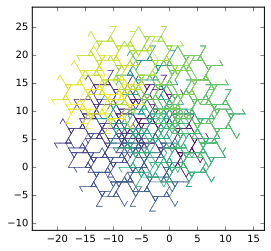

In [15]:
rule = randrules[11].copy()
rule['iter'] = 8
lsystem = Lsystem.from_lsbot(**rule)
series = lsystem.interpret(rule['iter'] - 1)
series = [list(zip(*s)) for s in series]
plot_series(series, linewidth=0.5)
pprint(rule)

In [6]:
#for i, r in enumerate(randrules):
#    r['iter'] = r.get('iter', 5)
#    iters = r['iter'] - 1
#    lsystem = Lsystem.from_lsbot(**r)
#    series = lsystem.interpret(iters)
#    series = [zip(*s) for s in series]
#    plot_series(series, linewidth=0.25, savefig='temp_{}'.format(i))